In [1]:
import torch
from datasets import load_dataset
from transformers import (
    RobertaTokenizerFast,
    RobertaTokenizer,
    RobertaForSequenceClassification,
    TrainingArguments,
    Trainer,
    AutoConfig,
)
# from sklearnex import patch_sklearn
# patch_sklearn()

import gc
import json
import pickle
import numpy as np    
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.metrics import accuracy_score, f1_score, classification_report
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

2024-04-18 10:40:16.665659: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-18 10:40:16.665782: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-18 10:40:16.783212: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


/kaggle/input/train_file.json
/kaggle/input/val_file.json


In [2]:
PATH='/kaggle/input/'
OUTPATH=''
# PATH="data/"
# OUTPATH='output/'
BATCH_SIZE=20
MAX_LENGTH=128
MAX_UTTERANCES=25
EPOCHS=10
EOS='</s>'
SEP='[SEP]'
SOS='<s>'

torch.manual_seed(0)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "roberta-base"
# device="cpu"
label_encoding ={
    'surprise':1,
    'sadness':2,
    'anger':3,
    'fear':4,
    'disgust':5,
    'joy':6,
    'neutral':0
}

In [3]:
# read json
def get_data(file_path):
    global label_encoding
    with open(file_path) as f:
        data = json.load(f)
        # to pandas
        df = pd.DataFrame(data)

    sentence_len = []
    text=[]
    text_len=[]

    for i in range(len(df)):
        uterances=df.iloc[i]['utterances']
        speaker=df.iloc[i]['speakers']
        length=0
        sentences=[]
        for (speaker,uterance) in zip(speaker,uterances):
            sentence=speaker+': '+uterance
            sentences.append(sentence)
            length+=len(uterance.split())
        if(length==2):
            print(sentence)
            print(df.iloc[i])
        sentence_len.append(length)
        text_len.append(len(sentences))
        text.append(sentences)
        # print(length)
        # break
    y=[]
    for i in df["emotions"]:
        lst=[]
        for j in i:
            lst.append(label_encoding[j])
        if(len(lst)>MAX_UTTERANCES):
            lst=lst[:MAX_UTTERANCES]
        else:
            lst.extend([-100]*(MAX_UTTERANCES-len(lst)))
        y.append(lst)
    x=[]
    for i in text:
        lst=[]
        for j in i:
            lst.append(j)
        if(len(lst)>MAX_UTTERANCES):
            lst=lst[:MAX_UTTERANCES]
        else:
            lst.extend([EOS]*(MAX_UTTERANCES-len(lst)))
        # print(lst)
        # print(len(lst))
        x.append(lst)

    # return x[:100],y[:100]
    return x,y

In [4]:
x_train, y_train = get_data(PATH+"train_file.json")
x_val, y_val = get_data(PATH+'val_file.json')

Phoebe: No!
episode          utterance_915
speakers      [Phoebe, Phoebe]
emotions      [neutral, anger]
utterances          [No., No!]
triggers            [0.0, 0.0]
Name: 968, dtype: object
Phoebe: No!
episode          utterance_915
speakers      [Phoebe, Phoebe]
emotions      [neutral, anger]
utterances          [No., No!]
triggers            [0.0, 0.0]
Name: 3984, dtype: object


In [5]:
ii=17
x_train[ii],y_train[ii]

(['Rachel: They made you head of the department!',
  "Ross: No, I get to teach one of his advanced classes!  Why didn't I get head of the department?",
  'Joey: Oh! Hey Rach, listen umm',
  'Rachel: Yeah.',
  'Joey: I got a big date coming up, do you know a good restaurant?',
  "Rachel: Uh, Paul's Café. They got great food and it's really romantic.",
  'Joey: Ooh, great! Thanks!',
  'Rachel: Yeah! Oh, and then afterwards you can take her to the',
  "Joey: You sure are naming a lot of ways to postpone sex, I'll tell ya",
  'Rachel: Ooh, I miss dating.',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>',
  '</s>'],
 [6,
  6,
  0,
  0,
  0,
  0,
  6,
  0,
  0,
  2,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100,
  -100])

In [6]:
from torch import nn
tokenizer = RobertaTokenizer.from_pretrained(model_id)


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

In [7]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data, tokenizer,labels):
        self.data=data
        self.tokenizer = tokenizer
        self.labels = labels
    
    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):   
        encoded_pair = self.tokenizer(self.data[idx],max_length=MAX_LENGTH,truncation=True,return_tensors="pt",padding="max_length")
        # print(encoded_pair)
        input_ids = encoded_pair['input_ids'].squeeze(0)
        attention_mask = encoded_pair['attention_mask'].squeeze(0)
        return input_ids,attention_mask,torch.tensor(self.labels[idx])

In [8]:
train_dataset = Dataset(x_train,tokenizer,y_train)
val_dataset = Dataset(x_val,tokenizer,y_val)

In [9]:
for i in train_dataset:
    for j in i:
        print(len(j))
    break

25
25
25


In [10]:
from torch.utils.data import DataLoader
train_dataloader=DataLoader(train_dataset,batch_size=BATCH_SIZE,shuffle=False)
val_dataloader=DataLoader(val_dataset,batch_size=BATCH_SIZE,shuffle=False)

Roberta output should be of size BATCH_SIZExlabels, we need linear layer to output BATCH_SIZExlabels as emotions in one way or another after we will do softmax. Now manage this. 

In [11]:

class EmotionClassifier(nn.Module):
    def __init__(self, roberta_model, roberta_labels,num_labels):
        super(EmotionClassifier, self).__init__()
        self.roberta_labels = roberta_labels
        self.num_labels = num_labels
        self.roberta = roberta_model
        self.roberta.requires_grad_(False)  
        for param in self.roberta.roberta.encoder.layer[-3:].parameters():
            param.requires_grad = True
            
#         self.LSTM = nn.LSTM(MAX_UTTERANCES*roberta_labels, 128, 2, batch_first=True)
#         self.linear = nn.Linear(128, MAX_UTTERANCES*num_labels) 
        self.linear = nn.Linear(MAX_UTTERANCES*roberta_labels, MAX_UTTERANCES*num_labels)

        
    def forward(self, input_ids, attention_mask, token_type_ids=None):
        outputs = self.roberta(input_ids=input_ids, attention_mask=attention_mask,token_type_ids=token_type_ids)
        output_logits=outputs.logits # output: (50,10)
        batch_size = output_logits.shape[0]//MAX_UTTERANCES
        output_logits=output_logits.view(batch_size,MAX_UTTERANCES*self.roberta_labels) # (2,25*10)
        # print("OUTPUT: ",output_logits.shape) # now working correctly
        
        logits = self.linear(output_logits)
        logits=logits.view(batch_size,MAX_UTTERANCES,self.num_labels)
        # print("logits: ",logits.shape)
        softmax_output = nn.functional.softmax(logits, dim=-1)
        # print("softmax: ",softmax_output.shape)
        return softmax_output
    
num_labels = 7
roberta_labels = 10
dropout_prob = 0.07
config = AutoConfig.from_pretrained(model_id)
config.num_labels = roberta_labels
config.hidden_dropout_prob = dropout_prob
config.attention_probs_dropout_prob = dropout_prob
roberta_model = RobertaForSequenceClassification.from_pretrained(model_id,config=config)
model = EmotionClassifier(roberta_model,roberta_labels, num_labels)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(),lr=5e-5)
criterion = nn.functional.cross_entropy



train_losses=[]
val_losses=[]


model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [12]:
def train_epoch(model, optimizer,epoch):
    model.train()
    losses = 0
    for batch in tqdm(train_dataloader, desc=f"Epoch:{epoch}",total=len(train_dataloader), leave=False):
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        # token_type_ids = batch[2].to(device)
        labels = batch[2].to(device)
        # print("train: ",labels.shape,input_ids.shape,attention_mask.shape)
        utterance_wise_batch={}
        batch_size=input_ids.shape[0]
        utterance_input_ids=input_ids.view(MAX_UTTERANCES*batch_size,-1)
        utterance_attention_mask=attention_mask.view(MAX_UTTERANCES*batch_size,-1)
        # for i in range(BATCH_SIZE):
        #     for j in range(MAX_UTTERANCES):
        #         utterance_input_ids.append(input_ids[i][j])
        #         utterance_attention_mask.append(attention_mask[i][j])
        # print(len(utterance_wise_batch),utterance_wise_batch[0])
        # utterance_input_ids=torch.stack(utterance_input_ids)
        # utterance_attention_mask=torch.stack(utterance_attention_mask)
        utterance_wise_batch['input_ids']=utterance_input_ids
        utterance_wise_batch['attention_mask']=utterance_attention_mask
        # print(utterance_input_ids.shape,utterance_attention_mask.shape,len(utterance_wise_batch))
        optimizer.zero_grad()
        predicted = model(utterance_input_ids, utterance_attention_mask)
        # print("lables: ",labels.shape)
        predicted=predicted.view(-1,num_labels)
        labels=labels.view(-1)
        loss = criterion(predicted, labels)
        losses += loss.item()
        loss.backward()
        optimizer.step()
        del input_ids
        del attention_mask
        del labels
        del predicted
        del utterance_input_ids
        del utterance_attention_mask
        del utterance_wise_batch
        gc.collect()
        torch.cuda.empty_cache()
        # break
    x = losses / len(list(train_dataloader))
    train_losses.append(x)
#     wandb.log({'epoch':epoch,'train_loss':x})
    tqdm.write(f"Epoch:{epoch}, Avg Train Loss: {x}")
    gc.collect()
    torch.cuda.empty_cache()
    return x



def evaluate(model,val_dataloader,name):
    with torch.no_grad():
        model.eval()
        losses = 0

        all_labels = []
        for batch in tqdm(val_dataloader, desc=name,total=len(val_dataloader), leave=False):
            input_ids = batch[0].to(device)
            attention_mask = batch[1].to(device)
            labels = batch[2].to(device)
            utterance_wise_batch={}
            batch_size=input_ids.shape[0]
            utterance_input_ids=input_ids.view(MAX_UTTERANCES*batch_size,-1)
            utterance_attention_mask=attention_mask.view(MAX_UTTERANCES*batch_size,-1)
            utterance_wise_batch['input_ids']=utterance_input_ids
            utterance_wise_batch['attention_mask']=utterance_attention_mask
            predicted = model(utterance_input_ids, utterance_attention_mask)
            predicted=predicted.view(-1,num_labels)
            labels=labels.view(-1)
            loss = criterion(predicted, labels)
            losses += loss.item()
            predicted_labels = predicted.argmax(dim=-1)
            all_labels.extend(predicted_labels.cpu().numpy())
            del input_ids
            del attention_mask
            del labels
            del predicted
            del utterance_input_ids
            del utterance_attention_mask
            del utterance_wise_batch
            gc.collect()
            torch.cuda.empty_cache()
            # break
        x = losses / len(list(val_dataloader))
        val_losses.append(x)
        tqdm.write(f"Avg {name} Loss: {x}")
        gc.collect()
        torch.cuda.empty_cache()
        return x, all_labels
    



In [13]:
gc.collect()
torch.cuda.empty_cache()

In [14]:
gc.collect()
torch.cuda.empty_cache()
for epoch in range(1, EPOCHS+1):
    train_loss = train_epoch(model, optimizer,epoch)
    val_loss,all_labels = evaluate(model,val_dataloader=val_dataloader,name='Val')
    torch.save(model, f"{OUTPATH}modelM1_epoch{epoch}.pth")
    print((f"Epoch: {epoch}, Train loss: {train_loss:.3f}, Val loss: {val_loss:.3f}"))

Epoch:1:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:1, Avg Train Loss: 1.770277371038669


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.7314423710800881
Epoch: 1, Train loss: 1.770, Val loss: 1.731


Epoch:2:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:2, Avg Train Loss: 1.7309834065706158


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.7170568011527838
Epoch: 2, Train loss: 1.731, Val loss: 1.717


Epoch:3:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:3, Avg Train Loss: 1.6873287234886463


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.6484830379486084
Epoch: 3, Train loss: 1.687, Val loss: 1.648


Epoch:4:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:4, Avg Train Loss: 1.620335959892952


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.5897045440452044
Epoch: 4, Train loss: 1.620, Val loss: 1.590


Epoch:5:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:5, Avg Train Loss: 1.570427462679696


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.5497036701024964
Epoch: 5, Train loss: 1.570, Val loss: 1.550


Epoch:6:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:6, Avg Train Loss: 1.527826552928732


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.5090542699015417
Epoch: 6, Train loss: 1.528, Val loss: 1.509


Epoch:7:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:7, Avg Train Loss: 1.4885907265128298


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.4708268947379535
Epoch: 7, Train loss: 1.489, Val loss: 1.471


Epoch:8:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:8, Avg Train Loss: 1.4496451736557732


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.434501708940018
Epoch: 8, Train loss: 1.450, Val loss: 1.435


Epoch:9:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:9, Avg Train Loss: 1.4135864378790473


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.4034056857574817
Epoch: 9, Train loss: 1.414, Val loss: 1.403


Epoch:10:   0%|          | 0/337 [00:00<?, ?it/s]

Epoch:10, Avg Train Loss: 1.3844404132146864


Val:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Val Loss: 1.3764947236970413
Epoch: 10, Train loss: 1.384, Val loss: 1.376


In [15]:
torch.save(model, f"{OUTPATH}modelM1.pth")
torch.save(tokenizer, f"{OUTPATH}tokenizerM1.pth")

In [16]:
train_losses,val_losses

([1.770277371038669,
  1.7309834065706158,
  1.6873287234886463,
  1.620335959892952,
  1.570427462679696,
  1.527826552928732,
  1.4885907265128298,
  1.4496451736557732,
  1.4135864378790473,
  1.3844404132146864],
 [1.7314423710800881,
  1.7170568011527838,
  1.6484830379486084,
  1.5897045440452044,
  1.5497036701024964,
  1.5090542699015417,
  1.4708268947379535,
  1.434501708940018,
  1.4034056857574817,
  1.3764947236970413])

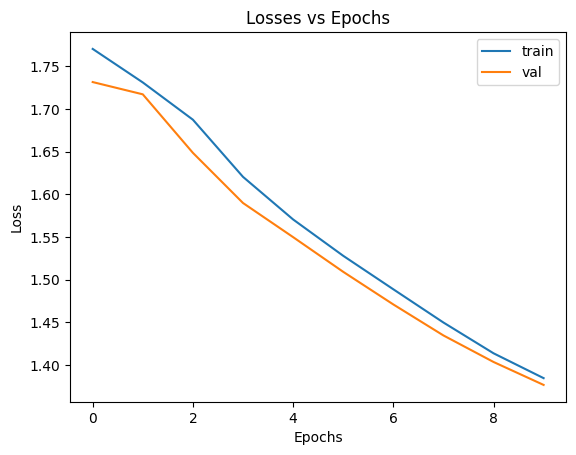

In [17]:
# plot losses
import matplotlib.pyplot as plt
plt.plot(train_losses,label='train')
plt.plot(val_losses,label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Losses vs Epochs')
plt.legend()
plt.show()


In [18]:
# load model
loaded_model = torch.load(f"{OUTPATH}modelM1.pth")
loaded_tokenizer = torch.load(f"{OUTPATH}tokenizerM1.pth")

# test
x_test, y_test = get_data(PATH+'val_file.json')
test_dataset = Dataset(x_test,loaded_tokenizer,y_test)
test_dataloader=DataLoader(test_dataset,batch_size=BATCH_SIZE,shuffle=False)
test_loss,all_labels = evaluate(loaded_model,test_dataloader,name='Test')


Test:   0%|          | 0/43 [00:00<?, ?it/s]

Avg Test Loss: 1.3764947236970413


In [19]:
c = 0
for i in y_test:
    c+=len(i)
print(c)
print(len(all_labels))

21075
21075


In [20]:
# print(y_test)
# print(all_labels)

In [21]:
y_test_list = []
for i in y_test:
    for j in i:
        y_test_list.append(j)

In [22]:
print(f"Test loss: {test_loss:.3f}")
f1_sccore = f1_score(y_test_list, all_labels, average='weighted')
f1_macro = f1_score(y_test_list, all_labels, average='macro')
print(f1_macro,f1_sccore)
print(classification_report(y_test_list, all_labels))

Test loss: 1.376
0.292763800084574 0.14283723740000193
              precision    recall  f1-score   support

        -100       0.00      0.00      0.00     13782
           0       0.27      1.00      0.42      3200
           1       0.38      0.85      0.52      1008
           2       0.38      0.25      0.30       558
           3       0.36      0.76      0.49       788
           4       0.07      0.08      0.08       265
           5       0.11      0.11      0.11       215
           6       0.27      0.95      0.42      1259

    accuracy                           0.29     21075
   macro avg       0.23      0.50      0.29     21075
weighted avg       0.10      0.29      0.14     21075



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
dic1={}
dic2={}
for i in y_test_list:
    if i in dic1:
        dic1[i]+=1
    else:
        dic1[i]=1

for i in all_labels:
    if i in dic2:
        dic2[i]+=1
    else:
        dic2[i]=1

dic1,dic2


({3: 788, 0: 3200, 1: 1008, 5: 215, 4: 265, 2: 558, -100: 13782, 6: 1259},
 {1: 2276, 0: 11885, 3: 1653, 2: 367, 4: 313, 6: 4373, 5: 208})

In [24]:
p=[]
a=[]
for i in range(len(y_test_list)):
    if(y_test_list[i]!=-100):
        # print(y_test_list[i],preds[i])
        p.append(all_labels[i])
        a.append(y_test_list[i])

print(classification_report(a,p))
f1_s=f1_score(a,p,average=None)

for label, f1 in enumerate(f1_s):
    print(f"F1 score for label {label}: {f1}")

dic1={}
dic2={}
for i in range(len(p)):
    if p[i] in dic1:
        dic1[p[i]]+=1
    else:
        dic1[p[i]]=1
    if a[i] in dic2:
        dic2[a[i]]+=1
    else:
        dic2[a[i]]=1

dic2,dic1


              precision    recall  f1-score   support

           0       0.83      1.00      0.91      3200
           1       0.82      0.85      0.84      1008
           2       0.93      0.25      0.39       558
           3       0.81      0.76      0.78       788
           4       1.00      0.08      0.15       265
           5       0.96      0.11      0.19       215
           6       0.80      0.95      0.87      1259

    accuracy                           0.83      7293
   macro avg       0.88      0.57      0.59      7293
weighted avg       0.84      0.83      0.79      7293

F1 score for label 0: 0.908806373595106
F1 score for label 1: 0.8367546432062559
F1 score for label 2: 0.39038189533239037
F1 score for label 3: 0.7819843342036553
F1 score for label 4: 0.15331010452961671
F1 score for label 5: 0.19246861924686195
F1 score for label 6: 0.8681718863801894


({3: 788, 0: 3200, 1: 1008, 5: 215, 4: 265, 2: 558, 6: 1259},
 {1: 1038, 0: 3829, 3: 744, 2: 149, 6: 1487, 5: 24, 4: 22})